In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
import os
import time
from train import train_and_evaluate_model, plot_individual_training_history, plot_combined_comparison, plot_confusion_matrix, save_results_to_csv_conv, save_results_to_csv_filters
import numpy as np
from model import create_cnn_model

# 1. Data Preprocessing

Memuat dan memproses Dataset CIFAR-10 untuk melakukan *Image Recognition* menggunakan CNN

Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)
Dataset sizes: Train=40000, Valid=10000, Test=10000
Classes in dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train label distribution: [3986 3986 4048 3984 4003 3975 4020 4023 3997 3978]
Validation label distribution: [1014 1014  952 1016  997 1025  980  977 1003 1022]
Test label distribution: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


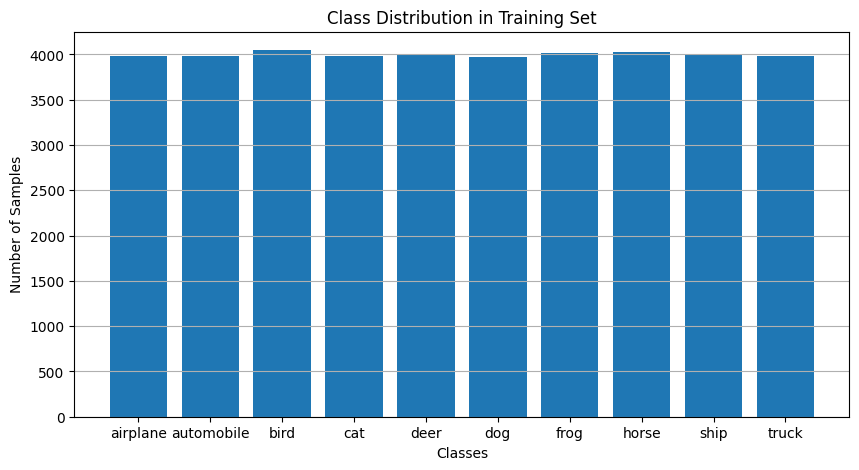


Sample data:


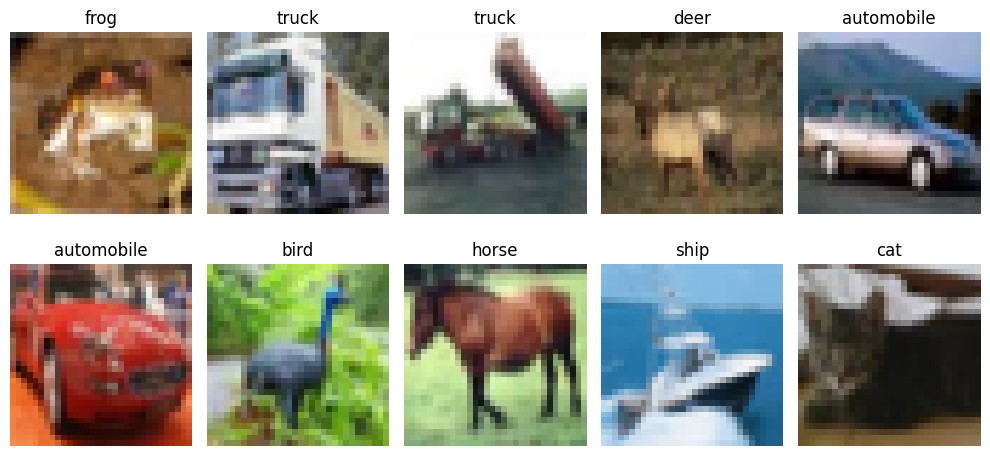

Image dimensions: Height=32, Width=32


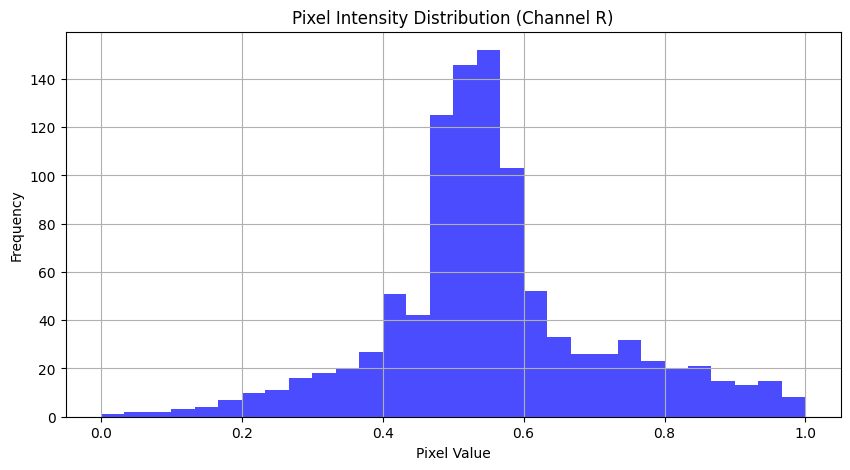

Sample image pixel statistics (Channel R):
Mean: 0.55
Median: 0.54
Max: 1.0


In [2]:
from data_preprocessing import load_cifar10_data

# Load CIFAR-10 dataset
(x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_cifar10_data()

# Print dataset sizes and class distribution
print(f"Dataset sizes: Train={len(x_train)}, Valid={len(x_val)}, Test={len(x_test)}")
print(f"Classes in dataset: {class_names}")
print(f"Train label distribution: {np.bincount(y_train)}")
print(f"Validation label distribution: {np.bincount(y_val)}")
print(f"Test label distribution: {np.bincount(y_test)}")

# Visualisasi distribusi kelas dalam dataset pelatihan
plt.figure(figsize=(10, 5))
train_class_counts = np.bincount(y_train)
plt.bar(class_names, train_class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.show()

# Menampilkan beberapa contoh gambar dari dataset
print("\nSample data:")
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Visualisasi dimensi citra gambar
image_heights = [img.shape[0] for img in x_train]
image_widths = [img.shape[1] for img in x_train]
print(f"Image dimensions: Height={image_heights[0]}, Width={image_widths[0]}")

# Visualisasi distribusi pixel citra gambar
sample_image = x_train[0]
pixel_values = sample_image[:, :, 0].flatten()  # Choose one channel (e.g., R in RGB)
plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=30, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution (Channel R)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display mean, median, and max values for pixel intensities
print(f"Sample image pixel statistics (Channel R):")
print(f"Mean: {np.mean(pixel_values):.2f}")
print(f"Median: {np.median(pixel_values):.2f}")
print(f"Max: {np.max(pixel_values)}")


# 2 Model CNN

Pada bagian ini, kita akan membuat serta melatih model CNN untuk melakukan klasifikasi gambar.

After Conv Layer 1, output shape: (None, 30, 30, 32)
After Conv Layer 2, output shape: (None, 13, 13, 64)

Training basic_cnn...
Epoch 1/10
1405/1407 [============================>.] - ETA: 0s - loss: 1.4879 - accuracy: 0.4658
Epoch 1: val_loss improved from inf to 1.16225, saving model to checkpoints\basic_cnn.weights.h5
1407/1407 [==============================] - 33s 23ms/step - loss: 1.4877 - accuracy: 0.4659 - val_loss: 1.1622 - val_accuracy: 0.5982 - lr: 0.0010
Epoch 2/10
1405/1407 [============================>.] - ETA: 0s - loss: 1.1141 - accuracy: 0.6102
Epoch 2: val_loss improved from 1.16225 to 1.05649, saving model to checkpoints\basic_cnn.weights.h5
1407/1407 [==============================] - 32s 23ms/step - loss: 1.1142 - accuracy: 0.6101 - val_loss: 1.0565 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 3/10
1406/1407 [============================>.] - ETA: 0s - loss: 0.9782 - accuracy: 0.6604
Epoch 3: val_loss improved from 1.05649 to 0.95917, saving model to checkpoints\bas

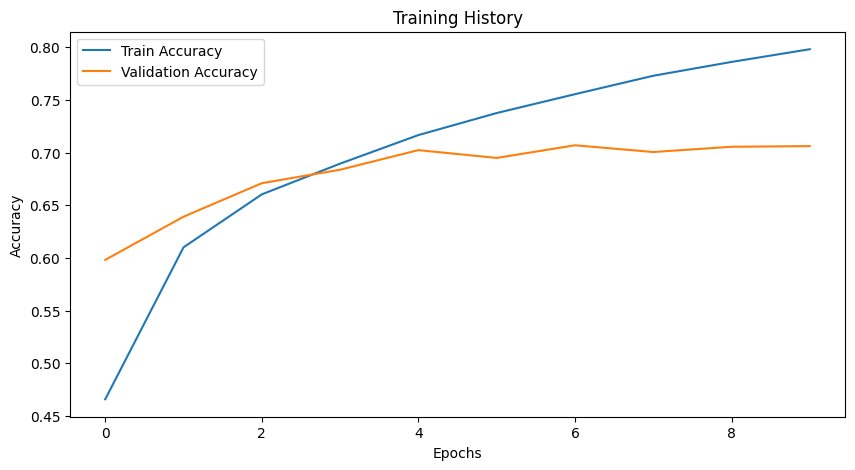

Test Loss: 0.9070
Test Accuracy: 0.6879
Test F1 Score: 0.6876


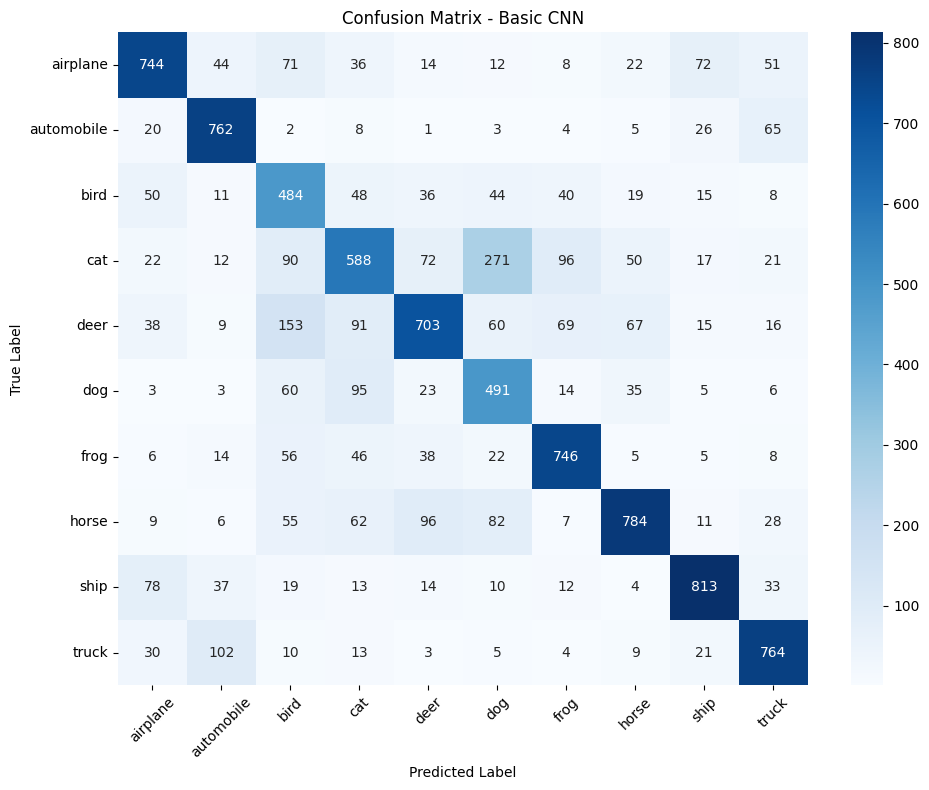


Classification Report:
              precision    recall  f1-score   support

    airplane       0.69      0.74      0.72      1000
  automobile       0.85      0.76      0.80      1000
        bird       0.64      0.48      0.55      1000
         cat       0.47      0.59      0.53      1000
        deer       0.58      0.70      0.63      1000
         dog       0.67      0.49      0.57      1000
        frog       0.79      0.75      0.77      1000
       horse       0.69      0.78      0.73      1000
        ship       0.79      0.81      0.80      1000
       truck       0.80      0.76      0.78      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



In [11]:
# Dataset CIFAR-10
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Normalisasi data
train_images, test_images = train_images / 255.0, test_images / 255.0

# Split validasi
valid_images = train_images[-5000:]
valid_labels = train_labels[-5000:]
train_images = train_images[:-5000]
train_labels = train_labels[:-5000]

# Buat model CNN dengan parameter default (model dasar)
model_cnn = create_cnn_model()

# Latih model menggunakan fungsi train_and_evaluate_model yang baru
model_cnn, history, test_f1 = train_and_evaluate_model(
    model=model_cnn,
    x_train=train_images,
    y_train=train_labels,
    x_val=valid_images,
    y_val=valid_labels,
    x_test=test_images,
    y_test=test_labels,
    model_name="basic_cnn",
    epochs=10
)

# Plot kurva training
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluasi model untuk mendapatkan metrik lengkap
test_loss, test_accuracy = model_cnn.evaluate(test_images, test_labels, verbose=0)
test_predictions = model_cnn.predict(test_images, verbose=0)

# Tampilkan metrik evaluasi
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Siapkan data untuk confusion matrix dan classification report
preds_cnn = np.argmax(test_predictions, axis=1)
labels_cnn = test_labels.flatten()

# Plot confusion matrix (jika fungsi tersedia)
try:
    plot_confusion_matrix(preds_cnn, labels_cnn, class_names, "Basic CNN")
except NameError:
    print("plot_confusion_matrix function not available")

# Tampilkan classification report
print("\nClassification Report:")
print(classification_report(labels_cnn, preds_cnn, target_names=class_names))

# 3. Eksperimen Variasi Parameter

Di bagian ini kita melakukan eksperimen untuk menguji pengaruh:
1. Jumlah layer konvolusi
2. Banyak filter per layer konvolusi
3. Ukuran filter per layer konvolusi
4. Jenis pooling layer


EXPERIMENT 1: EFFECT OF NUMBER OF CONVOLUTIONAL LAYERS
Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)

Training Model: 2_layers
After Conv Layer 1, output shape: (None, 32, 32, 32)
After Conv Layer 2, output shape: (None, 16, 16, 64)

Model Architecture - 2_layers:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8,

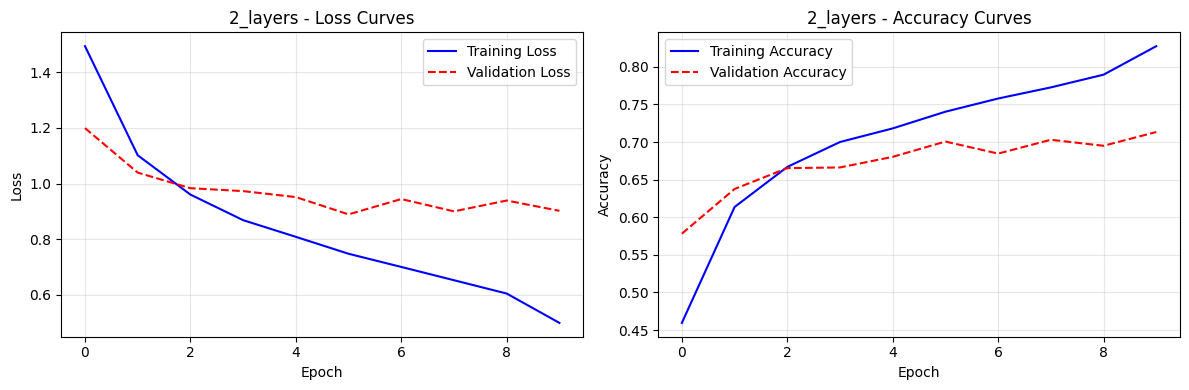


🔍 Confusion Matrix for 2_layers:


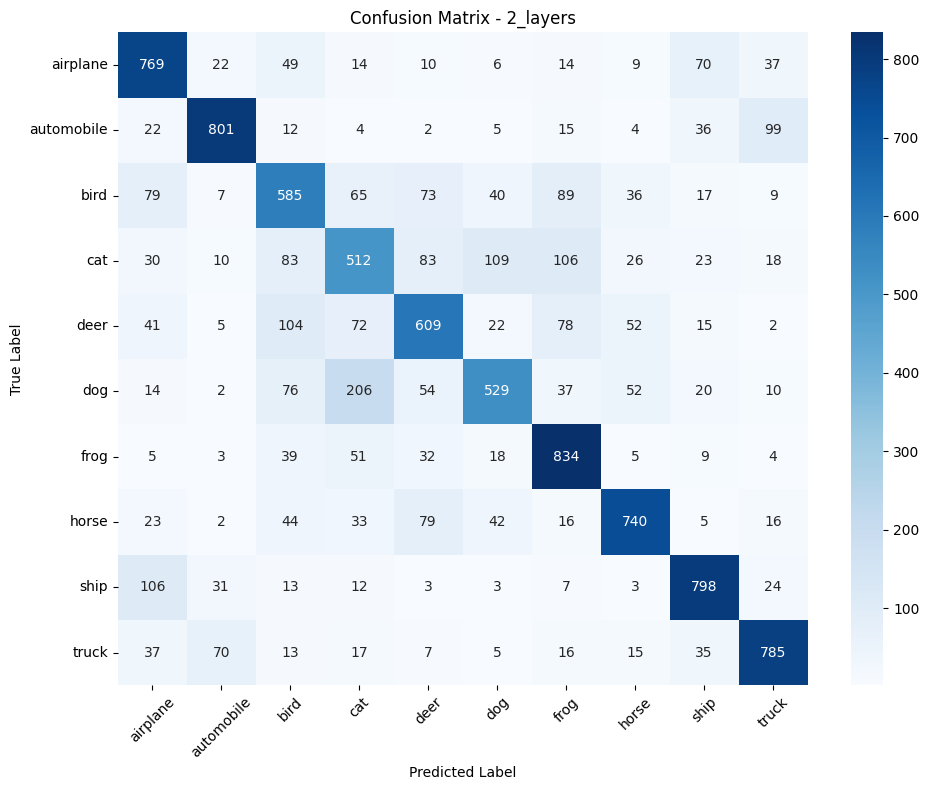

\nResults for 2_layers:
Test Accuracy: 0.6962
Test F1-Score: 0.6944
Test Loss: 0.8922
Training Time: 319.73 seconds

Training Model: 3_layers
After Conv Layer 1, output shape: (None, 32, 32, 32)
After Conv Layer 2, output shape: (None, 16, 16, 64)
After Conv Layer 3, output shape: (None, 8, 8, 128)

Model Architecture - 3_layers:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)      

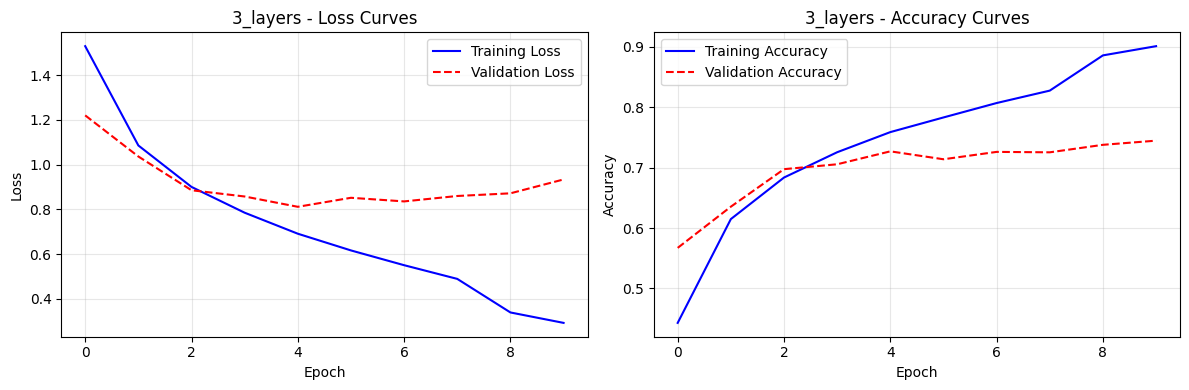


🔍 Confusion Matrix for 3_layers:


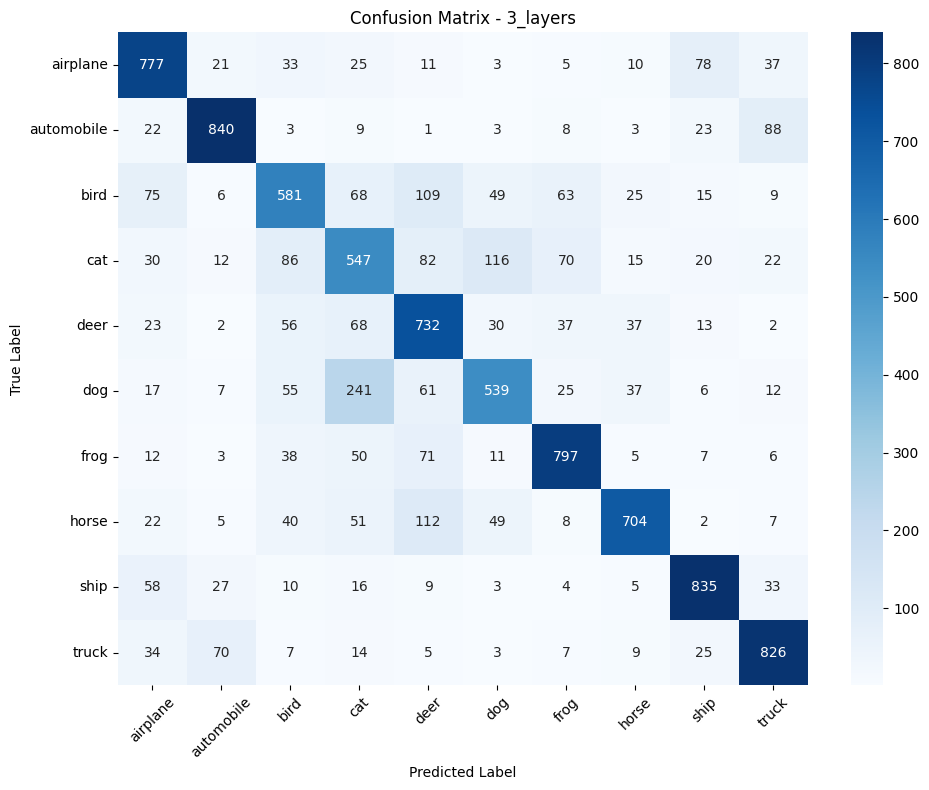

\nResults for 3_layers:
Test Accuracy: 0.7178
Test F1-Score: 0.7173
Test Loss: 0.8259
Training Time: 472.48 seconds

Training Model: 4_layers
After Conv Layer 1, output shape: (None, 32, 32, 32)
After Conv Layer 2, output shape: (None, 16, 16, 64)
After Conv Layer 3, output shape: (None, 8, 8, 128)
After Conv Layer 4, output shape: (None, 4, 4, 256)

Model Architecture - 4_layers:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 


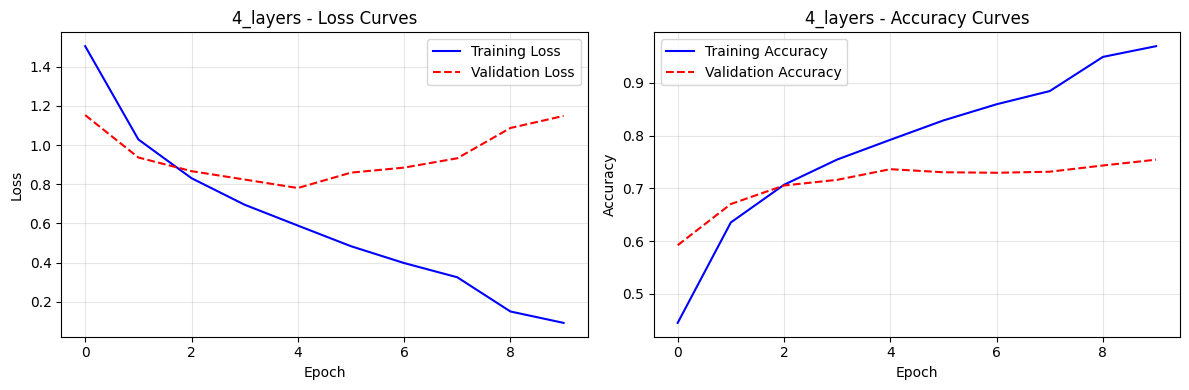


🔍 Confusion Matrix for 4_layers:


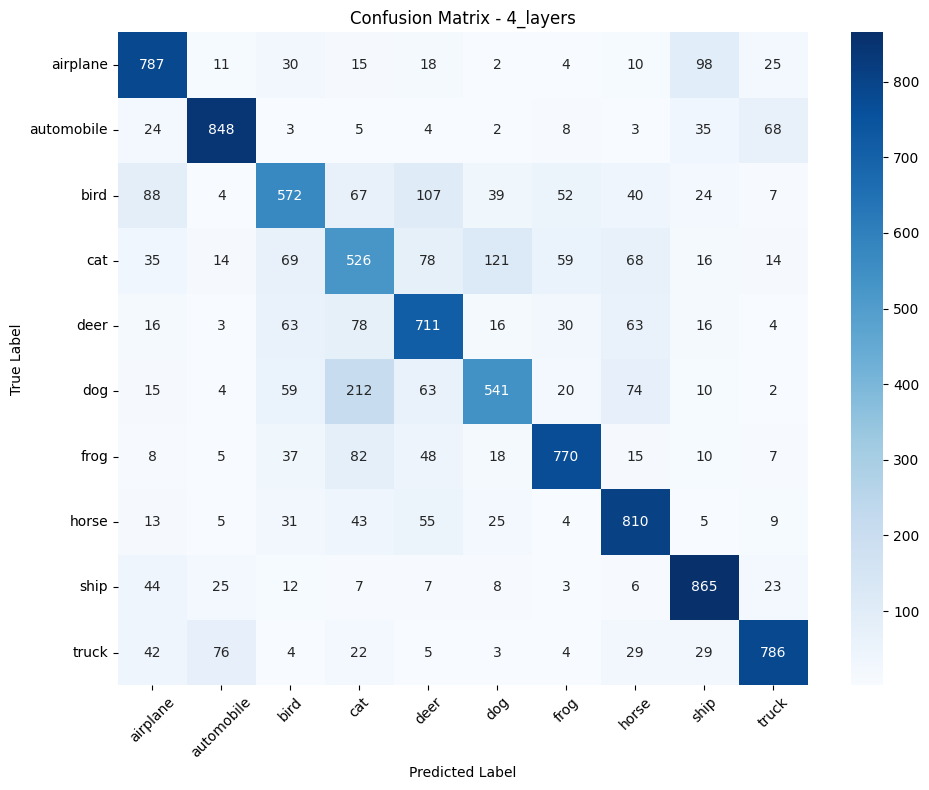

\nResults for 4_layers:
Test Accuracy: 0.7216
Test F1-Score: 0.7200
Test Loss: 0.8240
Training Time: 525.56 seconds

📈 Combined Comparison of All Models:


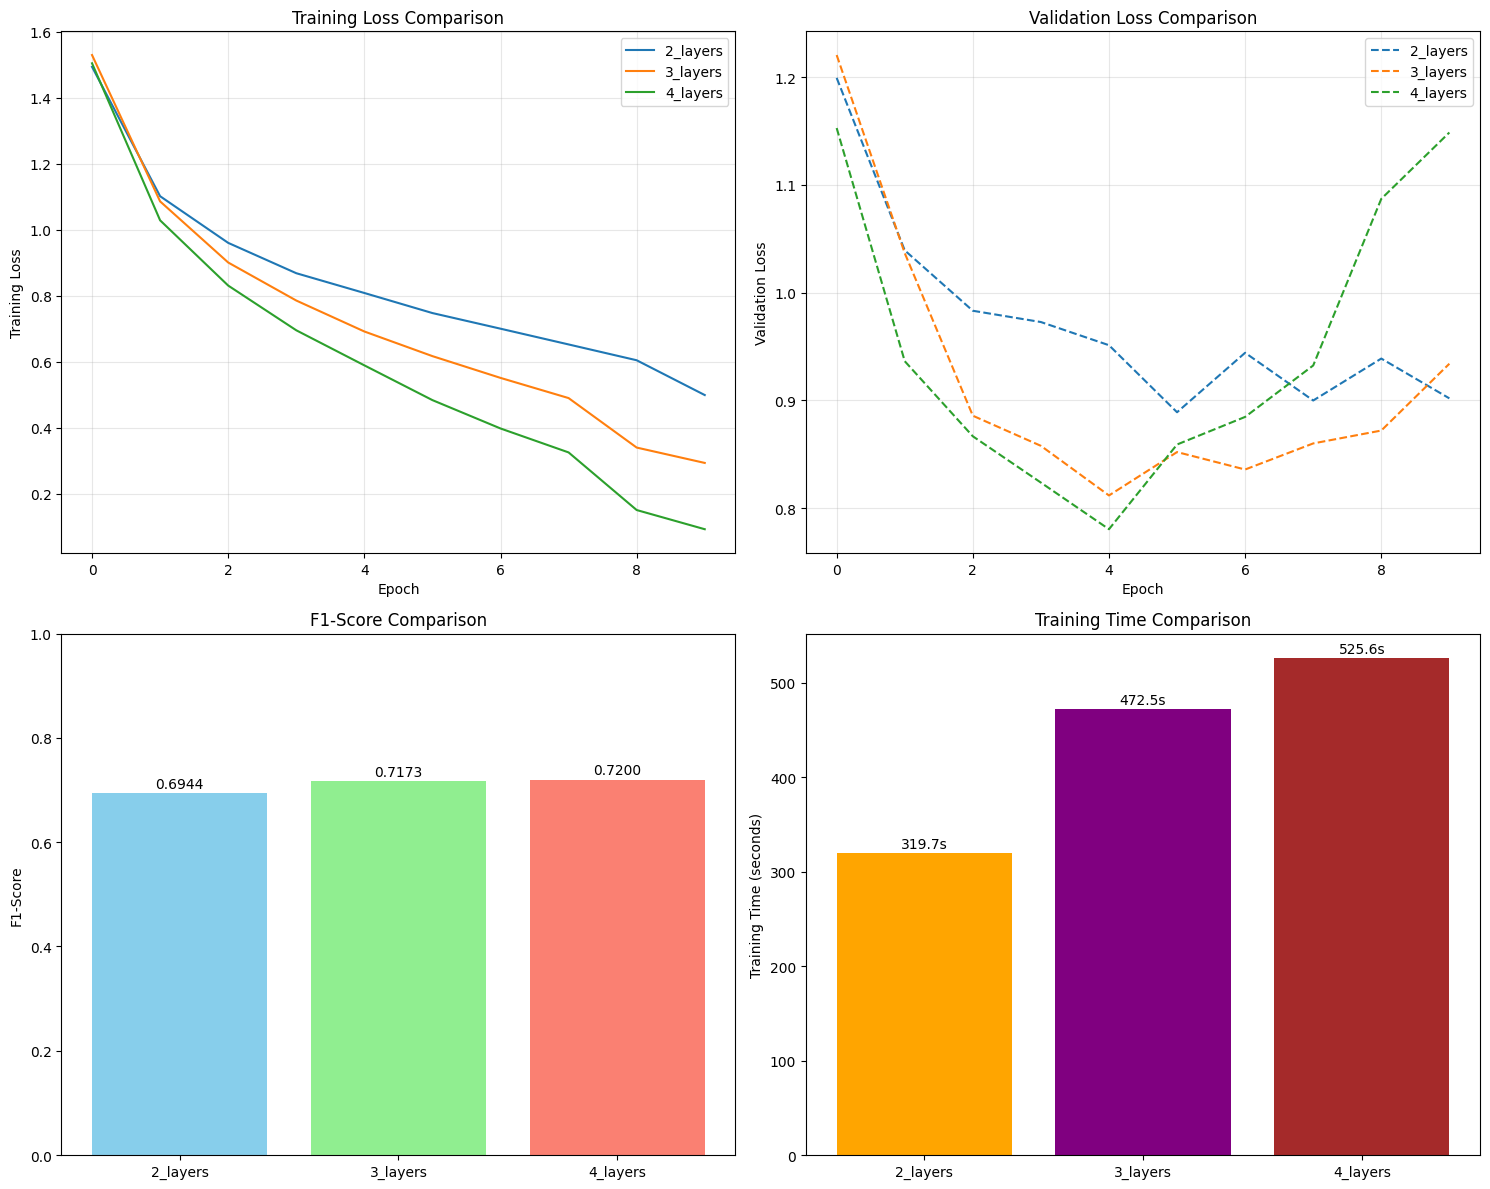

Results saved to experiment_results/conv_layers_experiment_results.csv

EXPERIMENT RESULTS SUMMARY
 num_layers  accuracy  f1_score     loss  train_time
          2    0.6962  0.694437 0.892222  319.731097
          3    0.7178  0.717328 0.825876  472.481964
          4    0.7216  0.719963 0.824000  525.564310

Best Model: 4_layers
Best F1-Score: 0.7200
Best Accuracy: 0.7216


In [ ]:
def experiment_conv_layers():
    """Experiment with different numbers of convolutional layers"""
    print("\n" + "="*60)
    print("EXPERIMENT 1: EFFECT OF NUMBER OF CONVOLUTIONAL LAYERS")
    print("="*60)
    
    # Load data
    (x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_cifar10_data()
    
    # Different number of convolutional layers
    conv_layer_configs = [
        (2, [32, 64], [3, 3]), # 2 layers
        (3, [32, 64, 128], [3, 3, 3]), # 3 layers
        (4, [32, 64, 128, 256], [3, 3, 3, 3]) # 4 layers
    ]
    
    models_list = []
    histories = []
    model_names = []
    f1_scores = []
    train_times = []
    accuracies = []
    final_losses = []
    
    # Create results directory for CSV only
    os.makedirs('results', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    
    for i, (num_layers, filters, kernels) in enumerate(conv_layer_configs):
        model_name = f"{num_layers}_layers"
        print(f"\n{'='*50}")
        print(f"Training Model: {model_name}")
        print(f"{'='*50}")
        
        model = create_cnn_model(
            conv_layers=num_layers,
            filters_per_layer=filters,
            kernel_sizes=kernels
        )
        
        # Print model summary
        print(f"\nModel Architecture - {model_name}:")
        model.summary()
        
        # Record start time
        start_time = time.time()
        
        # Train and evaluate
        trained_model, history, f1_score = train_and_evaluate_model(
            model, x_train, y_train, x_val, y_val, x_test, y_test, 
            model_name, epochs=10
        )
        
        # Record end time
        end_time = time.time()
        train_time = end_time - start_time
        
        # Get final test accuracy and loss
        test_loss, test_accuracy = trained_model.evaluate(x_test, y_test, verbose=0)
        
        # Store results
        models_list.append(trained_model)
        histories.append(history)
        model_names.append(model_name)
        f1_scores.append(f1_score)
        train_times.append(train_time)
        accuracies.append(test_accuracy)
        final_losses.append(test_loss)
        
        # Save individual model
        trained_model.save(f'models/cnn_{model_name}.keras')
        
        # Plot individual training history
        print(f"\n📊 Training Curves for {model_name}:")
        plot_individual_training_history(history, model_name)
        
        # Generate and plot confusion matrix
        test_predictions = trained_model.predict(x_test, verbose=0)
        y_pred = np.argmax(test_predictions, axis=1)
        
        print(f"\n🔍 Confusion Matrix for {model_name}:")
        plot_confusion_matrix(y_test, y_pred, class_names, model_name)
        
        print(f"\\nResults for {model_name}:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-Score: {f1_score:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")
    
    # Plot combined comparison
    print(f"\n📈 Combined Comparison of All Models:")
    plot_combined_comparison(histories, model_names, f1_scores, train_times)
    
    # Save results to CSV
    results_dir = 'experiment_results'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    results_df = save_results_to_csv_conv(
        model_names, accuracies, f1_scores, final_losses, train_times,
        'experiment_results/conv_layers_experiment_results.csv'
    )
    
    # Print final results summary
    print(f"\n{'='*60}")
    print("EXPERIMENT RESULTS SUMMARY")
    print(f"{'='*60}")
    print(results_df.to_string(index=False))
    
    # Print best model
    best_f1_idx = np.argmax(f1_scores)
    print(f"\nBest Model: {model_names[best_f1_idx]}")
    print(f"Best F1-Score: {f1_scores[best_f1_idx]:.4f}")
    print(f"Best Accuracy: {accuracies[best_f1_idx]:.4f}")
    
    return models_list, histories, model_names, f1_scores

conv_layer_models, conv_layer_histories, conv_layer_names, conv_layer_scores = experiment_conv_layers()


EXPERIMENT 2: EFFECT OF NUMBER OF FILTERS PER LAYER
Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)

Training Model: filters_16_32_64
After Conv Layer 1, output shape: (None, 30, 30, 16)
After Conv Layer 2, output shape: (None, 13, 13, 32)
After Conv Layer 3, output shape: (None, 4, 4, 64)

Model Architecture - filters_16_32_64:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        4640      
                                       

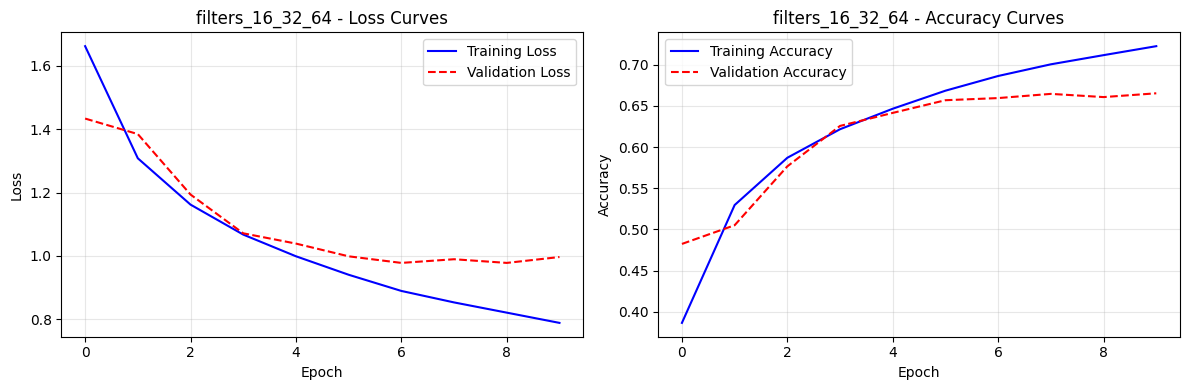


🔍 Confusion Matrix for filters_16_32_64:


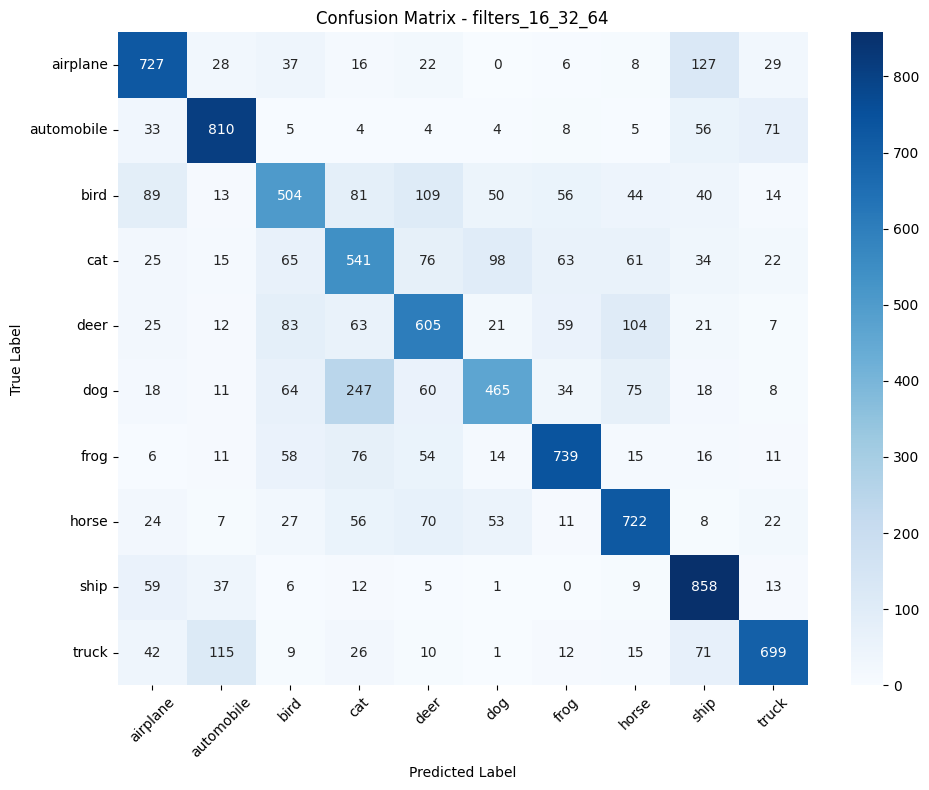


Results for filters_16_32_64:
Test Accuracy: 0.6670
Test F1-Score: 0.6640
Test Loss: 0.9760
Training Time: 161.23 seconds

Training Model: filters_32_64_128
After Conv Layer 1, output shape: (None, 30, 30, 32)
After Conv Layer 2, output shape: (None, 13, 13, 64)
After Conv Layer 3, output shape: (None, 4, 4, 128)

Model Architecture - filters_32_64_128:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin

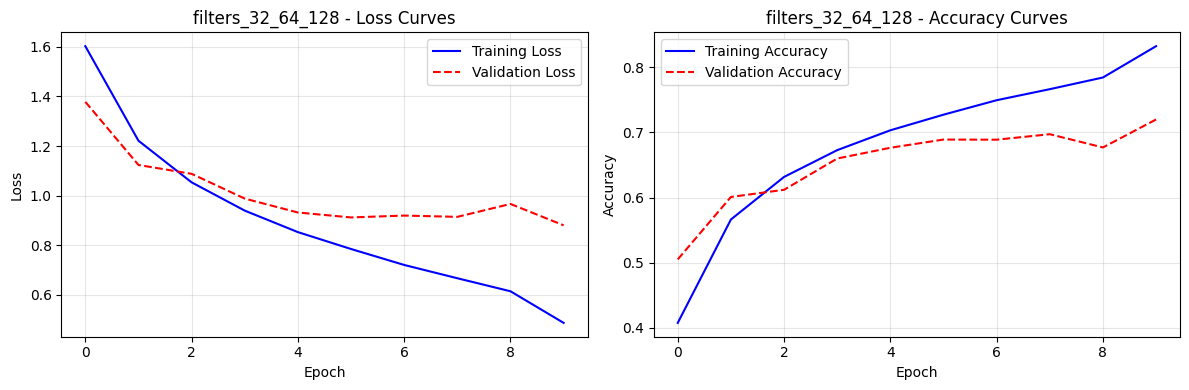


🔍 Confusion Matrix for filters_32_64_128:


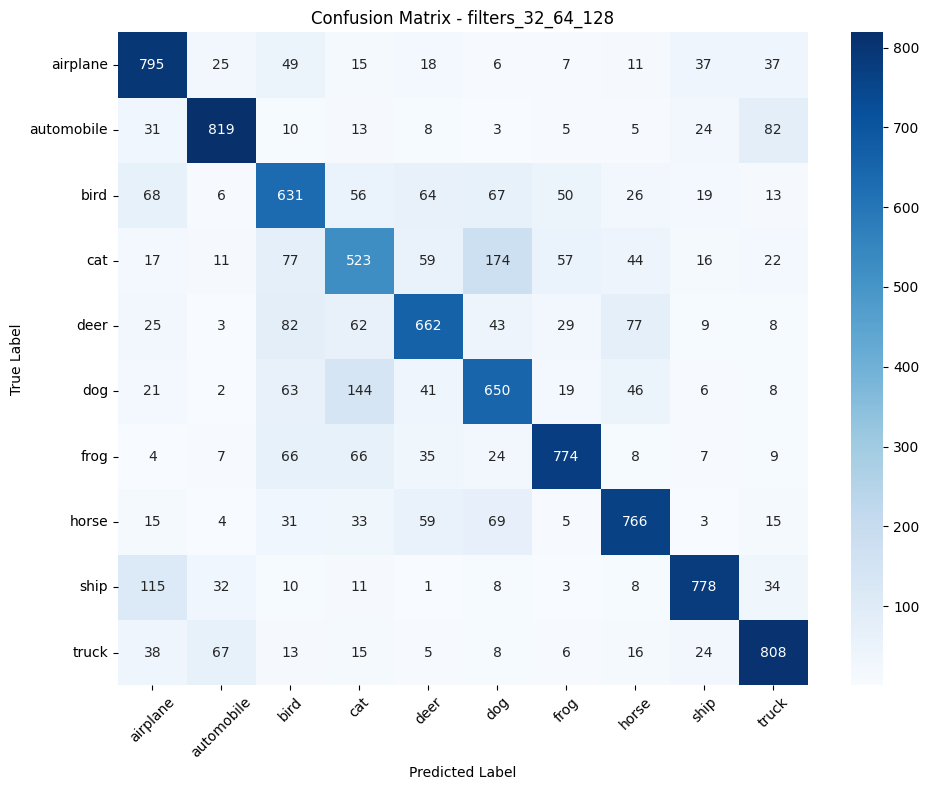


Results for filters_32_64_128:
Test Accuracy: 0.7206
Test F1-Score: 0.7206
Test Loss: 0.8884
Training Time: 280.32 seconds

Training Model: filters_64_128_256
After Conv Layer 1, output shape: (None, 30, 30, 64)
After Conv Layer 2, output shape: (None, 13, 13, 128)
After Conv Layer 3, output shape: (None, 4, 4, 256)

Model Architecture - filters_64_128_256:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPo

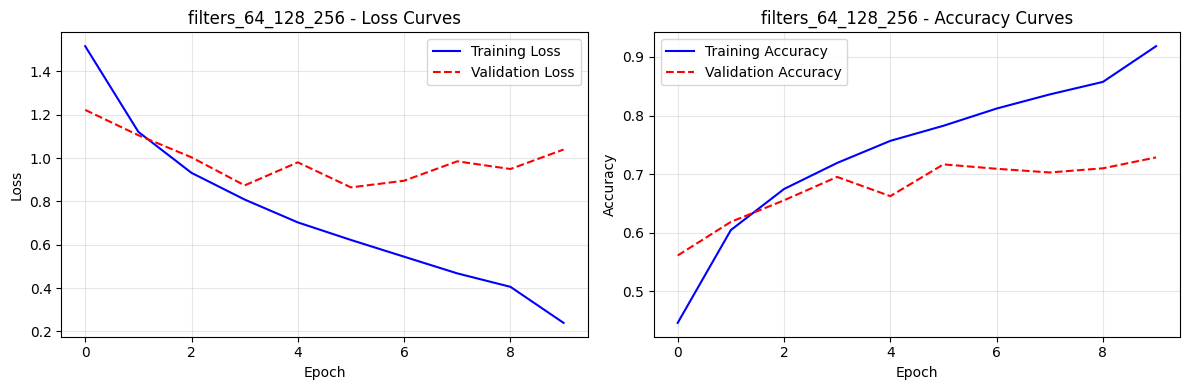


🔍 Confusion Matrix for filters_64_128_256:


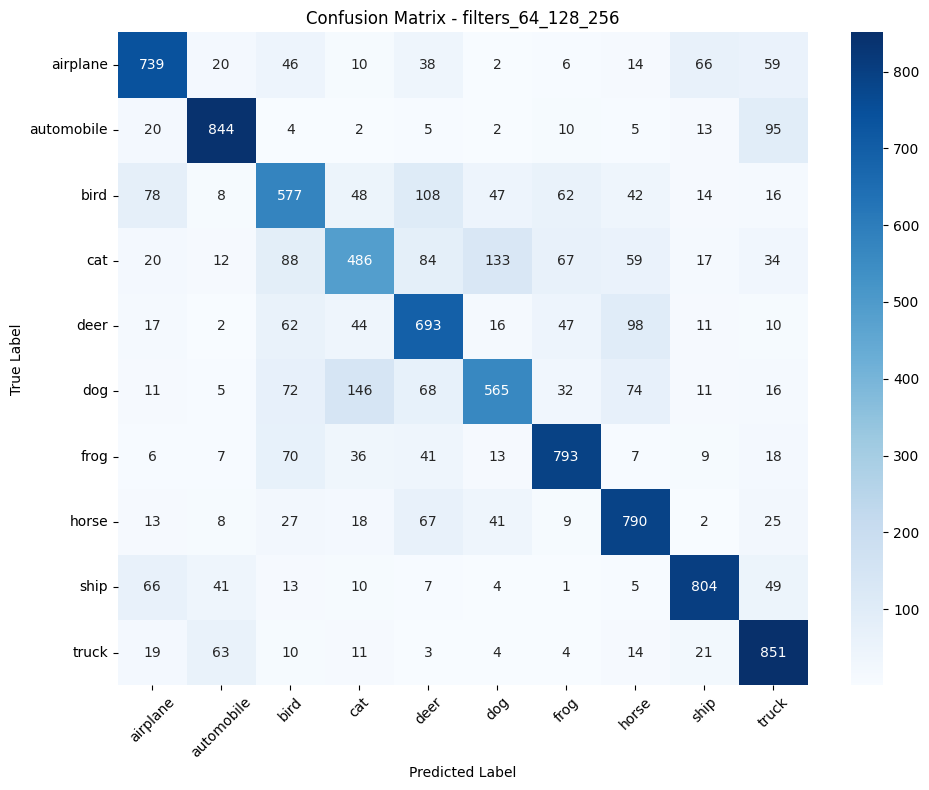


Results for filters_64_128_256:
Test Accuracy: 0.7142
Test F1-Score: 0.7111
Test Loss: 0.8650
Training Time: 516.29 seconds

📈 Combined Comparison of All Models:


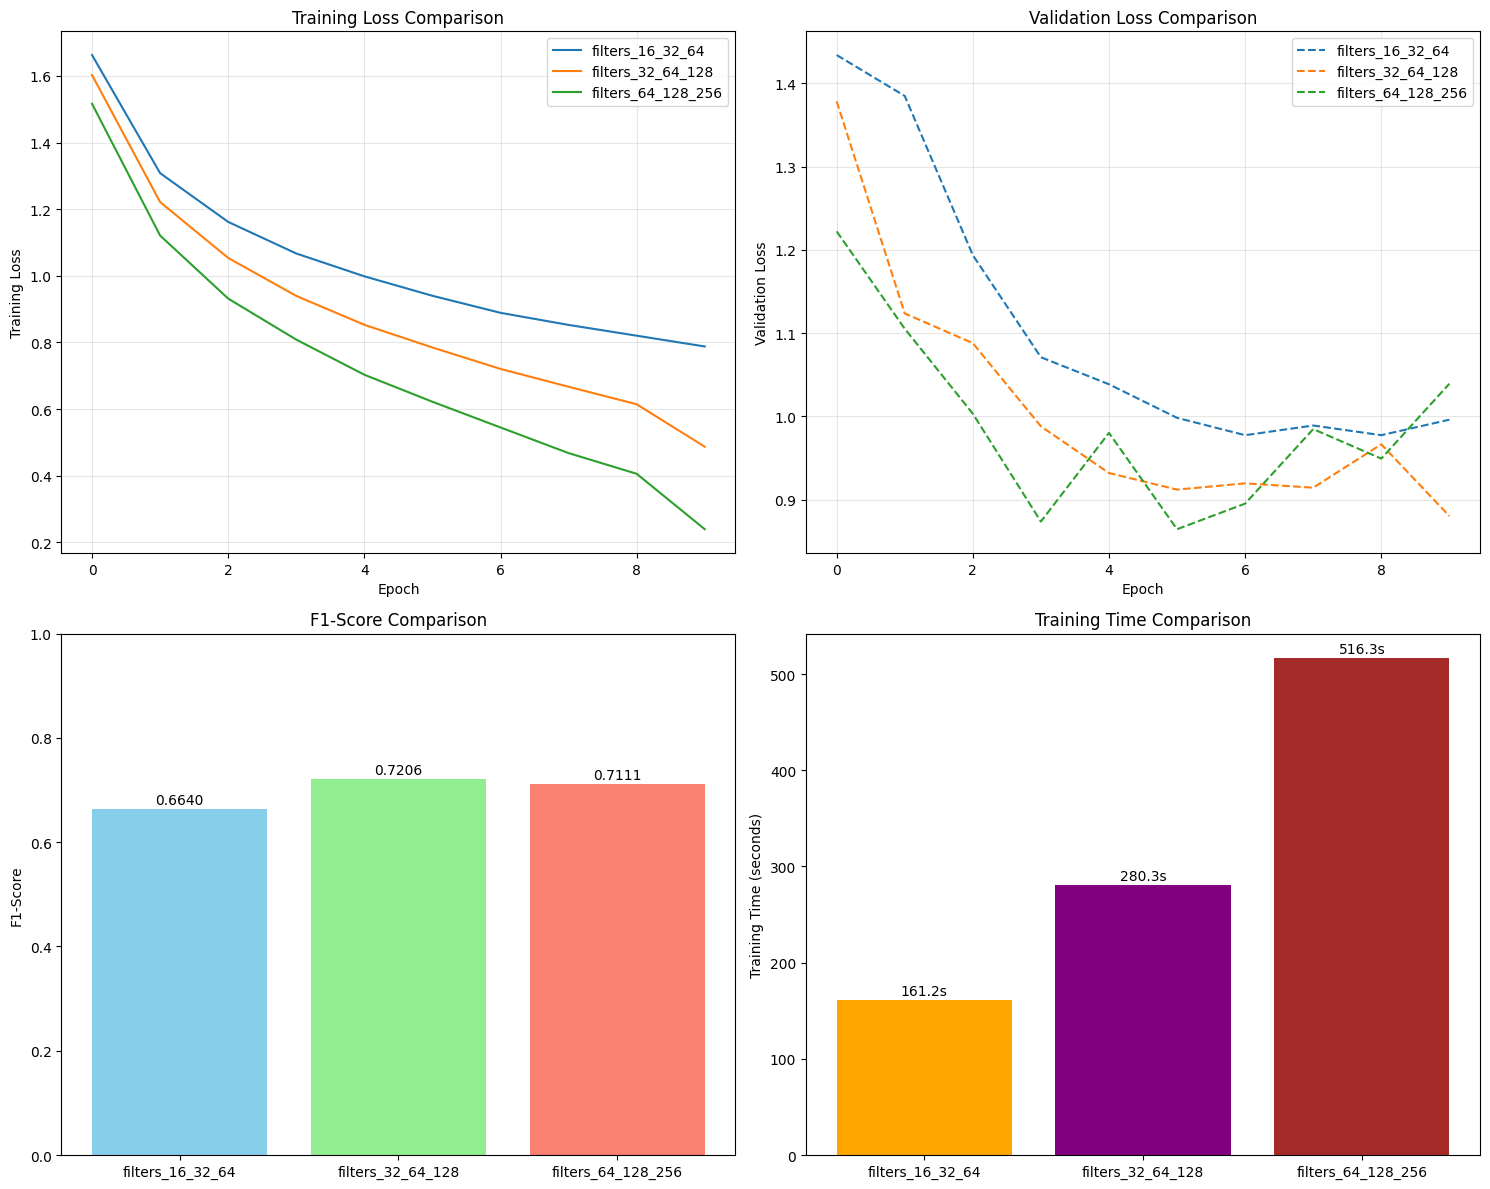

Results saved to experiment_results/filter_numbers_experiment_results.csv

EXPERIMENT RESULTS SUMMARY
filter_config  accuracy  f1_score     loss  train_time
     16-32-64    0.6670  0.663994 0.975955  161.230442
    32-64-128    0.7206  0.720639 0.888435  280.319793
   64-128-256    0.7142  0.711057 0.864992  516.288479

Best Model: filters_32_64_128
Best F1-Score: 0.7206
Best Accuracy: 0.7206


In [6]:
def experiment_filter_numbers():
    """Experiment with different numbers of filters per layer"""
    print("\n" + "="*60)
    print("EXPERIMENT 2: EFFECT OF NUMBER OF FILTERS PER LAYER")
    print("="*60)
    
    # Load data
    (x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_cifar10_data()
    
    # Different filter configurations
    filter_configs = [
        [16, 32, 64],    # Small filters
        [32, 64, 128],   # Medium filters
        [64, 128, 256]   # Large filters
    ]
    
    models_list = []
    histories = []
    model_names = []
    f1_scores = []
    train_times = []
    accuracies = []
    final_losses = []
    
    os.makedirs('experiment_results', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    
    for i, filters in enumerate(filter_configs):
        model_name = f"filters_{filters[0]}_{filters[1]}_{filters[2]}"
        print(f"\n{'='*50}")
        print(f"Training Model: {model_name}")
        print(f"{'='*50}")
        
        # Use the fixed model creation function
        model = create_cnn_model(
            conv_layers=3,
            filters_per_layer=filters,
            kernel_sizes=[3, 3, 3]
        )
        
        # Print model summary
        print(f"\nModel Architecture - {model_name}:")
        model.summary()
        
        # Record start time
        start_time = time.time()
        
        # Train and evaluate
        trained_model, history, f1_score = train_and_evaluate_model(
            model, x_train, y_train, x_val, y_val, x_test, y_test, 
            model_name, epochs=10
        )
        
        # Record end time
        end_time = time.time()
        train_time = end_time - start_time
        
        # Get final test accuracy and loss
        test_loss, test_accuracy = trained_model.evaluate(x_test, y_test, verbose=0)
        
        # Store results
        models_list.append(trained_model)
        histories.append(history)
        model_names.append(model_name)
        f1_scores.append(f1_score)
        train_times.append(train_time)
        accuracies.append(test_accuracy)
        final_losses.append(test_loss)
        
        # Save individual model
        trained_model.save(f'models/cnn_{model_name}.keras')
        
        # Plot individual training history
        print(f"\n📊 Training Curves for {model_name}:")
        plot_individual_training_history(history, model_name)
        
        # Generate and plot confusion matrix
        test_predictions = trained_model.predict(x_test, verbose=0)
        y_pred = np.argmax(test_predictions, axis=1)
        
        print(f"\n🔍 Confusion Matrix for {model_name}:")
        plot_confusion_matrix(y_test, y_pred, class_names, model_name)
        
        print(f"\nResults for {model_name}:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-Score: {f1_score:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")
    
    # Plot combined comparison
    print(f"\n📈 Combined Comparison of All Models:")
    plot_combined_comparison(histories, model_names, f1_scores, train_times)
    
    # Save results to CSV
    results_df = save_results_to_csv_filters(
        model_names, accuracies, f1_scores, final_losses, train_times,
        'experiment_results/filter_numbers_experiment_results.csv'
    )
    
    # Print final results summary
    print(f"\n{'='*60}")
    print("EXPERIMENT RESULTS SUMMARY")
    print(f"{'='*60}")
    print(results_df.to_string(index=False))
    
    # Print best model
    best_f1_idx = np.argmax(f1_scores)
    print(f"\nBest Model: {model_names[best_f1_idx]}")
    print(f"Best F1-Score: {f1_scores[best_f1_idx]:.4f}")
    print(f"Best Accuracy: {accuracies[best_f1_idx]:.4f}")
    
    return models_list, histories, model_names, f1_scores

filter_models, filter_histories, filter_names, filter_scores = experiment_filter_numbers()